# Notes

## Introduction
* Growing interest in combining the general-purpose learning capability of RL with the safety and robustness features of MPC.
* RL aims to learn a global value function through offline exploration in an uncertain environment, whereas MPC constructs a local value function through online optimization.
* This local-global perspective suggests new ways to design policies that combine robustness and goal-conditioned learning.
* Robustness is incorporated into the RL and MPC pipelines through a scenario-based approach. Goal-conditioned learning aims to alleviate the burden of engineering a reward function for RL.
* Combining the two leads to a single policy that unites a robust, high-level RL terminal value function with short-term, scenario-based MPC planning for reliable constraint satisfaction.
* Challenges in acquiring value function (a mechanism for predicting future performance): Unknown cost (Desirable performance is often difficult to quantify precisely); Unknown dynamics (Since real-world environments are never truly stationary or precisely known, robust approaches to learning and modeling are essential).
* An RL agent explores its environment to synthesize a high-level value function from a reward signal. This is a global approach wherein, at deployment, the RL agent simply queries its value-maximizing policy. On the other hand, MPC represents a modular strategy in which prior physical knowledge and safety specifications are directly embedded in the form of equality and inequality constraints. This results in a local value structure characterized by the agent continually replanning online.
* Contributions:
  - Use methods from robust MPC to design actions guided by constrainst and an RL terminal value function; and a scenario-based setup inspired by MPC to train the robust RL agent from simulated experience data.
  - Use goal-conditioned RL techniques to leran a high-level value function to augment the MPC agent.
  - Give a tutorial-style treatment of the local-global value function perspectives of MPC and RL. Elaborate on the implementation of robust MPC methods in an RL ecosystem.

## 2. Learning a global value function through RL

* Reward function is often defined and fine-tuned by a user through various metrics and penalty terms.
  - use dense rewards.
  - use hindsight.
  - HER is a technique in RL designed to improve leraning efficiency, especially in environments with sparse and binary rewards
  - the resulting dataset contains both the original and hindsight-relabeled tuples, resulting in additional "excitation" to the goal axis in the policy and value networks. Over time, the agent learns a better correspondence between goals and actions, making it able to reliably reach the desired targets. 

### 3. Building a local value function through MPC

* The LQR problem not only yields a quadratic global value function, but its simple structure lends itself to a tractable solution. This means we are now equipped with a formula that takes system and cost parameters and maps them to an optimal set of controller parameters.
* The practical and theoretical success of MPC is driven by this interplay between a global LQR value function and local replanning. The global LQR solution uses principles of dynamic programming to cache all the planning into an explicit policy. In turn, this alleviates the intractability of infinite-horizon planning. 

### 4. A brief survey of RL-MPC interface

* Value function-augmented MPC.
  - A key benefit of value function-augmented MPC via RL is the ability to effectively shirnk the planning horizon. Instead, a significant amount of planning and uncertainty can be cached into the value function representation, whcih lends itself nicely to stochastic systems.
  - A time-weighted averaging strategy that blends together the MPC and an RL-learned value estimate, taking advantage of prior information while enabling feedback from the true environment.
* MPC as a function approximator
  - Another line of work takes the view that MPC - its model, stage cost, constraints, and terminal value function - represents a set of parameters that can be steered towards optimality using RL.
  - In the context of deep RL, Romero propose an actor-critic setup in which the actor feeds cost coefficients to a differentiable MPC module.
* The value function-augmented schemes allow for more structural separation, meaning the value function can be trained in a deep RL pipeline, possibly offline based on prior system knowledge, and ported to the online MPC agent.


### 5. Robust goal-conditioned control policies

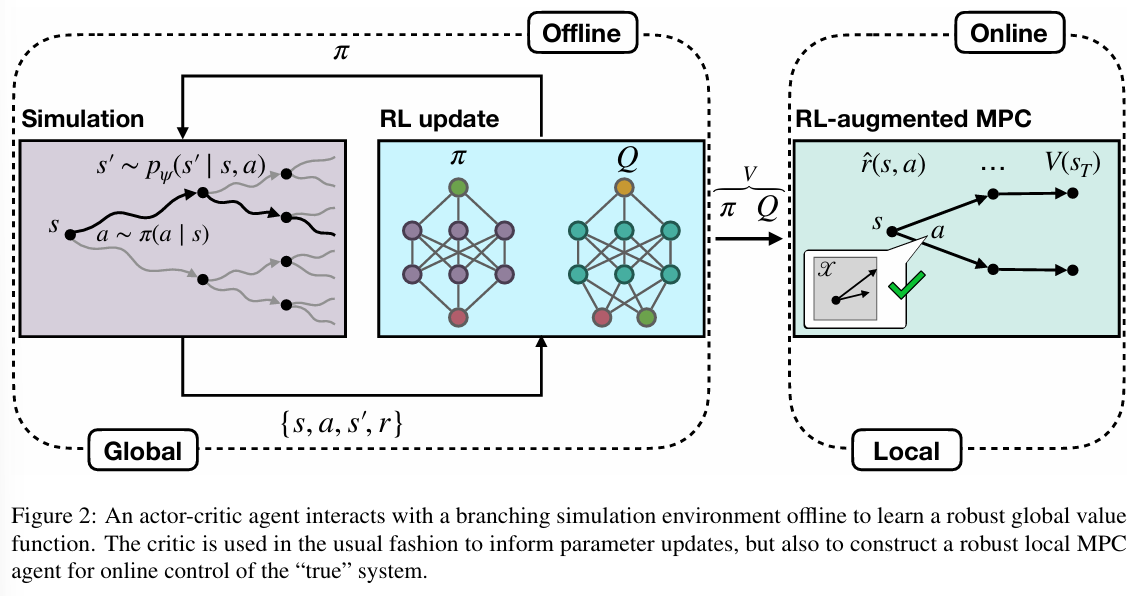
* assume an uncertain dynamic model of the environment is available: some prior knowledge is available, but not so much that we have a perfect represetantaion of the underlying dynamics. Robustness is incorporated into the framework thorugh the uncertain system description:
  - Robustness of the online agent: use a robust scenario-based MPC agent, which incorporates a distrbution of system uncertainties into its predictions. Specifically, the MPC agent constructs a scenario tree to tabulate costs and account for constraints over different situations.
  - Formulate a scenario-based value function based on the distribution of system uncertainties. This leads to a robust Bellman equation, which serves as a target for the RL agent ot learn simply through a branching process during offline rollouts. General off-policy actor critic algorithms are applicable for this portion of the framework.
  - Essentially, this scenario-based approach to robustness aligns the robust RL-learned value function witht he short-term, uncertain MPC predictions.
  - Although a model is available, we target complicated objectives where a straightforward implementation of MPC may not be suitable. Consequently, we leverage model-free RL techniques to directly learn the optimal value function from offline exploration.
  - After training such an RL agent offline, an MPC agent generates actions using short-term, scenario-based predictions and the RL value function as a terminal cost. Specifically, the MPC agent makes these predictions subject to constraints and system uncertainty. Together, this combination of RL and MPC produces a robust and safe goal-conditioned policy.
* Scenario-based MPC:
  - considers a scenario tree in its planning to help cope with uncertainty. A scenario is essentially a realization of the system model under some uncertainty specification. System uncertainty is general under our framework, but some possible sources include structural model unceratinty, model parameter uncertainty, or time-varying components.
* Offline MDP based on uncertain knowledge
  - A min-max formulation is a common strategy for training robust, although conservative, policies.
  - Another algorithmic approach is to train conservative agents with respect to static, offline datasets, leading to robustness in online performance.
  - Other approaches focus on imposing structural constraints on the policy architecture based on integral quadratic constraints to achieve robustness.
* A robust value function:
  - one could opt for a single uncertainty instance and hope that the resulting policy generalizes well to other scenarios -> in the spirit of option (1) the branching MDP is only a single (but specialized) environment, but experience from all scenarios informs the value estimation.
* Offline training and online deployment
  - For the general formulation, any off-policy actor-critic algorithm can be used wherein a policy $\pi$ is learned alongside a value function Q. Both are represented by a deep neural network.
  - Briefly, the policy network $\pi$ is used in the simulation envrionment to enable "fast" decision making and streamlined implementation. We then deploy the critic Q ont he "true" system, where an MPC agent designs actions subject to constraints and uncertainty intervals.
  - Branched rollouts: scenario set used for offline RL tranining may be larger thant he one in scenario-based MPC because the learned value function does not perform explicit planning upon deployment.
  - Goal-augmented state: For goal-conditioned learning, the state definition used in the environment contains the goal itself. The achieved goal could be the state itself, or some transformed version of the state, for instance, if the goal is an otuput value rather than a state value.


# Simulation / Code

The model class defines the DIP's dynamics, the MPC class sets up the control algorithm to regulate the DIP's behavior, and the simulator class creates the simulation environment to test and evaluate the system. 

In [1]:
# 1. Double Inverted Pendulum

# template mpc

def template_mpc(model, vf = None, goal = np.array([0.0, 0.0]), mpc_mode = "vfmpc", n_horizon=1, n_robust=0, silence_solver=True, solver="pardiso", store_full_solution=True,
                 RL_evn=False, uncertain_params="include_truth", var=1.0, input=10.0, ts=0.04, pos=10.0):
    """
    configures an MPC controller with various settings, constraints, and objectives to control a double inverted pendulum 
    template_mpc: tuning parameters
    """
    mpc = do_mpc.controller.MPC(model)
    mpc.settings.open_loop = False # close loop
    mpc.settings.t_step = ts
    mpc.settings.state_discretization='collocation'
    mpc.settings.collocation_type = 'radau'
    mpc.settings.collocation_deg = 3
    mpc.settings.collocation_ni = 1
    mpc.settings.store_full_solution = store_full_solution
    mpc.use_terminal_bounds=True

    if silence_solver:
        mpc.settings.supress_ipopt_output()
    mpc.nlpsol_opts = {'ipopt.linear_solver': solver}
    mpc.bounds['lower','_u','force'] = -input # lower 
    mpc.bounds ['upper','_u','force'] = input # upper 
    mpc.bounds['lower', '_x', 'pos'] = -pos # lower position
    mpc.bounds['upper', '_x', 'pos'] = pos # upper position

    # values for the masses (for robust MPC)
    if uncertain_params == "include_truth":
        m0_var = 0.6*np.array([1, 0.95, 1.05])
        m1_var = 0.2*np.array([1, 0.95, 1.05])
        m2_var = 0.2*np.array([1, 0.95, 1.05])
    elif uncertain_params == "missing_truth":
        m0_var = 0.6*np.array([0.95, 1.05])
        m1_var = 0.2*np.array([0.95, 1.05])
        m2_var = 0.2*np.array([0.95, 1.05])
    elif uncertain_params == "nominal":
        m0_var = 0.6*np.array([1.0])
        m1_var = 0.2*np.array([1.0])
        m2_var = 0.2*np.array([1.0])
    mpc.set_uncertainty_values(m0=m0_var, m1=m1_var, m2=m2_var)

    if mpc_mode == "goal-conditioned":
        mpc.settings.n_horizon =  n_horizon
        mpc.settings.n_robust =  n_robust
        mterm = 1-np.exp(-0.5*(model.aux['error_cos_theta1']**2 + model.aux['error_cos_theta2']**2) /  var) # terminal cost
        lterm = 1-np.exp(-0.5*(model.aux['error_cos_theta1']**2 + model.aux['error_cos_theta2']**2) / var) # stage cost
        mpc.set_objective(mterm=mterm, lterm=lterm)
        tvp_template = mpc.get_tvp_template()

        def tvp_fun(t_ind): 
            tvp_template['_tvp', :, 'goal_theta1'] = goal.flatten()[0]
            tvp_template['_tvp', :, 'goal_theta2'] = goal.flatten()[1]
            return tvp_template
        mpc.set_tvp_fun(tvp_fun)
        
    elif mpc_mode == "quadratic":
        mpc.settings.n_horizon =  n_horizon
        mpc.settings.n_robust =  n_robust
        # stage and terminal cost
        mterm = 0.5*(model.aux['error_cos_theta1']**2 + model.aux['error_cos_theta2']**2) # terminal cost
        lterm = 0.5*(model.aux['error_cos_theta1']**2 + model.aux['error_cos_theta2']**2) # stage cost
        mpc.set_objective(mterm=mterm, lterm=lterm)

        tvp_template = mpc.get_tvp_template()
        def tvp_fun(t_ind):
            # ind = t_ind // mpc.settings.t_step
            ind = t_ind // mpc.settings.t_step
            if ind <= 6.0 // mpc.settings.t_step:
                tvp_template['_tvp', :, 'goal_theta1'] = goal.flatten()[0]
                tvp_template['_tvp', :, 'goal_theta2'] = goal.flatten()[1]
            elif ind <= 12.0 // mpc.settings.t_step:
            # else:
                tvp_template['_tvp', :, 'goal_theta1'] = np.pi
                tvp_template['_tvp', :, 'goal_theta2'] = 0.0
            else:
                tvp_template['_tvp', :, 'goal_theta1'] = 0.0
                tvp_template['_tvp', :, 'goal_theta2'] = 0.0
            return tvp_template
        mpc.set_tvp_fun(tvp_fun # Method to set the function which returns the values of the time-varying parameters

    mpc.setup()

    return mpc

SyntaxError: expected default value expression (4120731981.py, line 5)

In [ ]:
def template_simulator(model, RL_env=False, uncertain_params="include_truth", eval_uncertain_env=False, goal=np.array([0.0, 0.0]), reltol=1e-1, ts=0.04):
    """
    sets up a simulation environment
    template_simulator : tuning parmaters
    """
    simulator = do_mpc.simulator.Simulator(model)
    params_simulator = {
        'integration_tool': 'idas',
        'abstol': 1e-8,
        'reltol': reltol,
        't_step': ts
    }
    simulator.set_param(**params_simulator)
    tvp_template = simulator.get_tvp_template()
    def tvp_fun(t_now):
        tvp_template['goal_theta1'] = goal.flatten()[0]
        tvp_template['goal_theta2'] = goal.flatten()[1]
        return tvp_template
    simulator.set_tvp_fun(tvp_fun) # Method to set the function which returns the values of the time-varying parameters
    p_num = simulator.get_p_template()
    num = 10
    if RL_env: # p_function is defined to randomly select mass values from the defined uncertainties during the sim
        # values for the masses (for robust MPC)
        if uncertain_params == "include_truth":
            m0_var = 0.6*np.array([1, 0.95, 1.05])
            m1_var = 0.2*np.array([1, 0.95, 1.05])
            m2_var = 0.2*np.array([1, 0.95, 1.05])
        elif uncertain_params == "missing_truth":
            m0_var = 0.6*np.linspace(1.05, 0.95, num)
            m1_var = 0.2*np.linspace(1.05, 0.95, num)
            m2_var = 0.2*np.linspace(1.05, 0.95, num)
        elif uncertain_params == "nominal":
            m0_var = 0.6*np.array([1.0])
            m1_var = 0.2*np.array([1.0])
            m2_var = 0.2*np.array([1.0])
        def p_fun(t_now):
            m0 = np.random.choice(m0_var)
            m1 = np.random.choice(m1_var)
            m2 = np.random.choice(m2_var)
            p_num['m0'], p_num['m1'], p_num['m2'] = m0, m1, m2                
            return p_num
    else: # sets the mass value to fixed values based on the uncertain_params parameter
        if uncertain_params == "out_of_distribution":
            p_num['m0'], p_num['m1'], p_num['m2'] = 0.5, 0.3, 0.3 
        else:
            p_num['m0'], p_num['m1'], p_num['m2'] = 0.6, 0.2, 0.2
        if eval_uncertain_env: # function selects random mass values once at the the start of the sim
            m0_var, m1_var, m2_var = [0.6*np.linspace(1.05, 0.95, num), 0.2*np.linspace(1.05, 0.95, num), 0.2*np.linspace(1.05, 0.95, num)]
            def p_fun(t_now):
                if t_now == 0.0:
                    m0 = np.random.choice(m0_var)
                    m1 = np.random.choice(m1_var)
                    m2 = np.random.choice(m2_var)
                    p_num['m0'], p_num['m1'], p_num['m2'] = m0, m1, m2
                return p_num
        else:
            def p_fun(t_now):
                return p_num
    simulator.set_p_fun(p_fun) # set to update the parameters during the sim
    simulator.setup()

    return simulator

In [ ]:
def template_model(symvar_type='MX'):
    """
    Sets a dynamic model for a double inverted pendulum 
    template_model: Variables / RHS / AUX
    """

    model_type = 'continuous'  # discrete or continuous
    model = do_mpc.model.Model(model_type, symvar_type

    # params
    m0 = 0.6  # kg, mass of the cart
    m1 = 0.2  # kg, mass of the first rod
    m2 = 0.2  # kg, mass of the second rod
    L1 = 0.5  #m, length of the first rod (DONT CHANGE)
    L2 = 0.5  #m, length of the second rod
    l1 = L1/2
    l2 = L2/2
    J1 = (m1 * l1**2) / 3   # Inertia
    J2 = (m2 * l2**2) / 3   # Inertia

    m0 = model.set_variable('_p', 'm0')
    m1 = model.set_variable('_p', 'm1')
    m2 = model.set_variable('_p', 'm2')

    g = 9.80665 # m/s^2, gravity

    h1 = m0 + m1 + m2
    h2 = m1*l1 + m2*L1
    h3 = m2*l2
    h4 = m1*l1**2 + m2*L1**2 + J1
    h5 = m2*l2*L1
    h6 = m2*l2**2 + J2
    h7 = (m1*l1 + m2*L1) * g
    h8 = m2*l2*g

    # setpoint x: 
    # pos_set = model.set_variable('_tvp', 'pos_set')
    goal_theta1 = model.set_variable('_tvp', 'goal_theta1')
    goal_theta2 = model.set_variable('_tvp', 'goal_theta2')
    goal_height = model.set_variable('_tvp', 'goal_height')
    # States struct (optimization variables):
    pos = model.set_variable('_x',  'pos')
    theta = model.set_variable('_x',  'theta', (2,1))
    dpos = model.set_variable('_x',  'dpos')
    dtheta = model.set_variable('_x',  'dtheta', (2,1))
    # Algebraic states:
    ddpos = model.set_variable('_z', 'ddpos')
    ddtheta = model.set_variable('_z', 'ddtheta', (2,1))
    # Input struct (optimization variables):
    u = model.set_variable('_u',  'force')

    # Differential equations
    model.set_rhs('pos', dpos)
    model.set_rhs('theta', dtheta)
    model.set_rhs('dpos', ddpos)
    model.set_rhs('dtheta', ddtheta)

    # Euler Lagrange equations for the DIP system (in the form f(x, u, z)=0)
    euler_lagrange = vertcat( # Concatenate arrays vertically
        # 1
        h1*ddpos+h2*ddtheta[0]*cos(theta[0])+h3*ddtheta[1]*cos(theta[1])
        - (h2*dtheta[0]**2*sin(theta[0]) + h3*dtheta[1]**2*sin(theta[1]) + u),
        # 2
        h2*cos(theta[0])*ddpos + h4*ddtheta[0] + h5*cos(theta[0]-theta[1])*ddtheta[1]
        - (h7*sin(theta[0]) - h5*dtheta[1]**2*sin(theta[0]-theta[1])),
        # 3
        h3*cos(theta[1])*ddpos + h5*cos(theta[0]-theta[1])*ddtheta[0] + h6*ddtheta[1]
        - (h5*dtheta[0]**2*sin(theta[0]-theta[1]) + h8*sin(theta[1]))
    )
    model.set_alg('euler_lagrange', euler_lagrange)
    # Expression for kinetic and potential energy
    E_kin_cart = 1 / 2 * m0 * dpos**2
    E_kin_p1 = 1 / 2 * m1 * (
        (dpos + l1 * dtheta[0] * cos(theta[0]))**2 +
        (l1 * dtheta[0] * sin(theta[0]))**2) + 1 / 2 * J1 * dtheta[0]**2
    E_kin_p2 = 1 / 2 * m2 * (
        (dpos + L1 * dtheta[0] * cos(theta[0]) + l2 * dtheta[1] * cos(theta[1]))**2 +
        (L1 * dtheta[0] * sin(theta[0]) + l2 * dtheta[1] * sin(theta[1]))**
        2) + 1 / 2 * J2 * dtheta[0]**2

    E_kin = E_kin_cart + E_kin_p1 + E_kin_p2

    E_pot = m1 * g * l1 * cos(
    theta[0]) + m2 * g * (L1 * cos(theta[0]) +
                                l2 * cos(theta[1]))
    # Set expression
    # Auxiliary expressions. CasADi symbolic structure, can be indexed with user-defined variable names.
    model.set_expression('E_kin', E_kin)
    model.set_expression('E_pot', E_pot)

    # model.set_expression('tvp', pos_set)
    model.set_expression('goal_theta1', goal_theta1)
    model.set_expression('goal_theta2', goal_theta2)
    model.set_expression('cos_goal_theta1', cos(goal_theta1))
    model.set_expression('cos_goal_theta2', cos(goal_theta2))
    model.set_expression('goal_height', goal_height)
    model.set_expression('cos_theta', cos(theta))
    model.set_expression('sin_theta', sin(theta))
    model.set_expression('height', 0.5*(cos(theta[0]) + cos(theta[1])))
    model.set_expression(expr_name='error_cos_theta1', expr = cos(goal_theta1) - cos(theta[0]))
    model.set_expression(expr_name='error_cos_theta2', expr = cos(goal_theta2) - cos(theta[1]))
    model.set_expression(expr_name='track_error_squared', expr = model.aux['error_cos_theta1']**2 + model.aux['error_cos_theta2']**2)
    model.set_expression(expr_name='cos_error_theta1', expr = 1 - cos(goal_theta1 - theta[0]))
    model.set_expression(expr_name='cos_error_theta2', expr = 1 - cos(goal_theta2 - theta[1]))
    model.set_expression(expr_name='error_height', expr = goal_height - model.aux['height'])

    # Build the model
    model.setup()

    return model

In [ ]:
# networks
class SoftQNetwork(nn.Module):
    
    def __init__(self, input_size:int=7):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64, 1)
    def forward(self, x, a):
        x = self._combine(x)
        x = self.q_value(x, a)
        return x
    def q_value(self, x, a):
        x = torch.cat([x, a], 1)
        x = self.q_value(x, a)
        return x
    def q_network(self, z):
        z = F.silu(self.fc1(z))  #Sigmoid Linear Unit (SiLU)
        z = F.silu(self.fc2(z))
        z = self.fc3(z)
        return z
    def _combine(self, x):
        x = torch.cat([x["observation"], x["desired_goal"] - x["achieved_goal"]], 1)
        return x

class ValueNetwork(nn.Module):
    def __init__(self, input_size:int=7):
        super().__init__()
        self.qf = SoftQNetwork(input_size=input_size)
    def forward(self, z):
        return self.qf.q_network(z)
    def _update(self, qf):
        for param, value_param in zip(qf.parameters(), self.qf.parameters()):
            value_param.data.copy_(param.data)
        return

class ActorValueNetwork(nn.Module):
    """
    An actor-critic network that uses a Q-network and an actor network to determine actions and evaluate their value
    """
    def __init__(self, qf, actor):
        super().__init__()
        self.qf = qf
        self.actor = actor
    def forward(self, z):
        a = self.actor.get_deterministic_action(z)
        z = torch.cat([z, a], 1)
        return self.qf(z)

class Actor(nn.Module):
    """
    actor network, which is responsible for generating actions given the state of the environment
    """
    def __init__(self, input_size:int=5, action_size:int=2, action_high=np.array([10.0, 0.0]), action_low=np.array([0.5, -8.5])):
        super().__init__()
        self.LOG_STD_MAX = 2
        self.LOG_STD_MIN = -5

        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc_mean = nn.Linear(64, action_size)
        self.fc_logstd = nn.Linear(64, action_size)

        self.register_buffer(
            "action_scale", torch.tensor((action_high - action_low) / 2.0, dtype=torch.float32).unsqueeze(0)
        )
        self.register_buffer(
            "action_bias", torch.tensor((action_high + action_low) / 2.0, dtype=torch.float32).unsqueeze(0)
        )

    def forward(self, x):
        x = self._combine(x)
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)
        log_std = self.LOG_STD_MIN + 0.5 * (self.LOG_STD_MAX - self.LOG_STD_MIN) * (log_std + 1)
        return mean, log_std

    def _combine(self, x):
        x = torch.cat([x["observation"], x["desired_goal"] - x["achieved_goal"]], 1)
        return x

    def _explore_noise(self, x):
        x = {"observation": torch.Tensor(x["observation"]), "desired_goal": torch.Tensor(x["desired_goal"])}
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean.zero_(), std)
        noise = normal.rsample() 

        return noise

    def get_action(self, x):
        mean, log_std = self(x)
        std = log_std.exp()
        normal = torch.distributions.Normal(mean, std)
        x_t = normal.rsample() 
        y_t = torch.tanh(x_t)
        action = y_t * self.action_scale + self.action_bias
        log_prob = normal.log_prob(x_t)
        # enforcing action bound
        log_prob -= torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6)
        log_prob = log_prob.sum(1, keepdim=True)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return action, log_prob, mean

    def get_deterministic_action(self, x):
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        mean = self.fc_mean(x)
        mean = torch.tanh(mean) * self.action_scale + self.action_bias
        return mean

In [1]:
### Evaluate a goal-conditioned MPC scheme for double inverted pendulum. 

from stable_baseline3.common.preprocessing import get_flattened_obs_dim
from casadi import *
import do_mpc

from rlmpc.utils.networks import SoftQNetwork, Valuenetwork, Actor, ActorValueNetwork
from rlmpc.envs.examples.DIP.template_model import template_model
from rlmpc.envs.examples.DIP.template_mpc import template_mpc
from rlmpc.envs.examples.DIP.template_simulator import template_simulator

control_strategy = "all"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initializes sampling planner
sp = do_mpc.sampling.SamplingPlanner() # A class for generating sampling plans
sp.set_param() # Set the parameters of the SamplingPlanner class

num_steps = 100
goal = np.array([0.0, 0.0]) # position, angle
uncertain_params = "include_truth" 
model = template_model() 

eval_same_goal = goal
solver = "MA27" # ipopt

estimator = do_mpc.estimator.StateFeedback(model) # Simple state-feedback “estimator”

# Add sampling variable including the corresponding evaluation function
n_horizon = [75]
var = [0.5]
strategies = ["goal-conditioned"]

sp.set_sampling_var('control_strategy')
sp.set_sampling_var('n_horizon')
sp.set_sampling_var('var')

plan = sp.product(n_horizon=n_horizon, var=var, control_strategy=strategies)  # Cartesian product of input variable

# pd.DataFrame(plan).head()

def run_closed_loop(control_strategy, n_horizon, var):
    mpc = template_mpc(model, mpc_mode=control_strategy, uncertain_parms=uncertain_params, solver=solver, store_full_solution=False, 
                       goal=eval_same_goal, var=var, n_horizon=n_horizon, ts=0.04, input=5.0, pos=5.0, silence_solver=True)
    simulator = template_simulator(model, uncertain_params=uncertain_params, goal=eval_same_goal, ts=0.04, reltol=1e-4)

    """
    Set initial state
    """
    if True:
        simulator.x0['theta'] = .9 * np.pi # initial angle
        simulator.x0['pos'] = 0.0

    x0 = simulator.x0.cat.full()
    # Reset the history of the optimizer
    mpc.reset_history()
    simulator.reset_history()
    estimator.reset_history()

    mpc.set_initial_guess()
    z0 = simulator.init_algebraic_variables()

    for _ in range(num_steps):
        u0 = mpc.make_step(x0)

        x0 = simulator.make_step(u0)
        x0 = estimator.make_step(x0)

    print("done") # done flag
    return simulator.data


# Initialize sampler with generated plan
sampler = do_mpc.sampling.Sampler(plan)
# Set the sampling function
sampler.set_sample_function(run_closed_loop)
# Generate the data
sampler.sample_data() # Generate samples based on a sampling plan. 

# Initialize DataHandler
dh = do_mpc.sampling.DataHandler(plan)
dh.data_dir = sampler_dir
# Set a post processing function. The post processing function is applied to all loaded samples
dh.set_post_processing('default', lambda data: data)
dh.set_post_processing('L1', lambda data: np.linalg.norm(data['_aux', 'error_cos_theta1'], ord=1) + np.linalg.norm(data['_aux', 'error_cos_theta2'], ord=1))
dh.set_post_processing('L2', lambda data: np.linalg.norm(data['_aux', 'error_cos_theta1'], ord=2) + np.linalg.norm(data['_aux', 'error_cos_theta2'], ord=2))
dh.set_post_processing('tv_input', lambda data: np.linalg.norm(np.diff(data['_u'], axis=0)))
dh.set_post_processing('time_near_goal', lambda data: np.sum(np.exp(-0.5*(np.linalg.norm(data['_aux', 'track_error_squared'],ord=2, axis=1) / 0.1)**2)))
dh.set_post_processing('fuzzy_pass_fail', lambda data: np.mean(np.exp(-0.5*(np.linalg.norm(data['_aux', 'track_error_squared'][num_steps//2::],ord=2, axis=1) / 0.1)**2)))

# df = pd.DataFrame(dh[:])
# df.to_pickle(sampler_dir+"smallvar_"+f"{n_horizon[0]}_"f"{uncertain_params}_"+"sample_data.pkl")
# df = pd.read_pickle(sampler_dir + "smallvar_" + f"{n_horizon[0]}_" + f"{uncertain_params}_" + "sample_data.pkl")
# print(df.head())

# from rlmpc.eval.dip_plot import episode_plot


SyntaxError: invalid syntax (3460077068.py, line 94)